Exercise 2.a

Importing libraries

In [357]:
from haralyzer import HarParser, HarPage
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import json
import pandas as pd
from pprint import pprint

Page Load Time

In [358]:
def fetch_page_load_time(har_file_path):
    with open(har_file_path, 'r') as f:
        har_data = json.load(f)
    
    pages = har_data['log']['pages']
    if len(pages) > 0:
        on_load_time = pages[0]['pageTimings'].get('onLoad', None) 
        return on_load_time
    else:
        raise ValueError("No pages found in HAR file.")

Loading time for each file

In [359]:
files=['IndiaPost_nothrottle.har','IndiaPost_Config1.har','IndiaPost_Config2.har','IndiaPost_Config3.har']
loading_time={}
for file in files:
    loading_time[file]=round(fetch_page_load_time(file),2)
pprint(loading_time)

{'IndiaPost_Config1.har': 296670.07,
 'IndiaPost_Config2.har': 35127.65,
 'IndiaPost_Config3.har': 28974.48,
 'IndiaPost_nothrottle.har': 13820.62}


Plotting the loading time

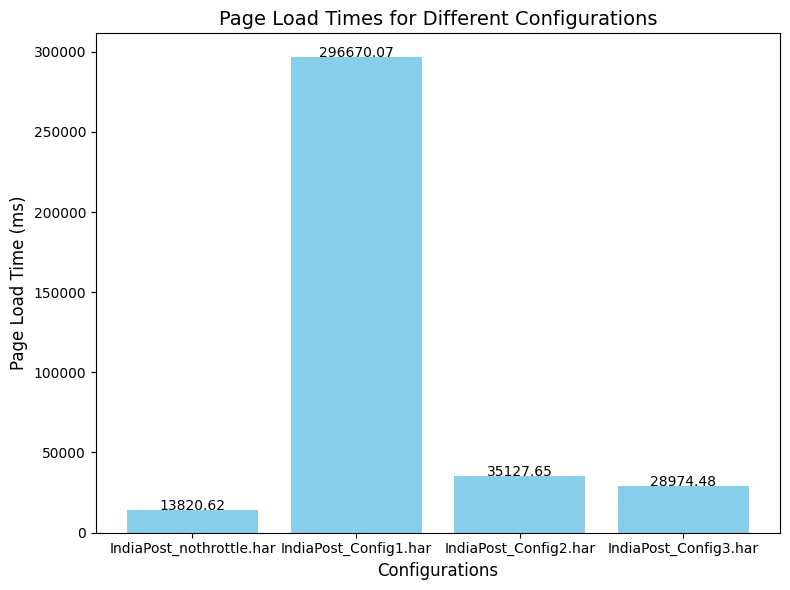

In [360]:
x_labels=loading_time.keys()
y_values=loading_time.values()
plt.figure(figsize=(8, 6))
plt.bar(x_labels, y_values, color='skyblue')
plt.xlabel("Configurations", fontsize=12)
plt.ylabel("Page Load Time (ms)", fontsize=12)
plt.title("Page Load Times for Different Configurations", fontsize=14)

for i, v in enumerate(y_values):
    plt.text(i, v + 50, str(v), ha='center', fontsize=10)

plt.tight_layout()
plt.show()

Exercise 2.b

Function for fetching requests and data

In [361]:
def fetch_requests_and_response_size(file):
    with open(file, 'r') as f:
            har_data = json.load(f)

    number_of_requests=len(har_data['log']['entries'])
    total_reponse_size=0
    for i in har_data['log']['entries']:
            total_reponse_size+=i['response']['bodySize']
            total_reponse_size+=i['response']['headersSize']

    return(number_of_requests,(round(total_reponse_size/(1024*1024),2)))


In [362]:
files=['IndiaPost_nothrottle.har','IndiaPost_Config1.har','IndiaPost_Config2.har','IndiaPost_Config3.har']
request_response={}
for file in files:
    request_response[file]=fetch_requests_and_response_size(file)
pprint(request_response)


{'IndiaPost_Config1.har': (102, 4.66),
 'IndiaPost_Config2.har': (102, 4.83),
 'IndiaPost_Config3.har': (102, 3.11),
 'IndiaPost_nothrottle.har': (102, 4.59)}


Excercise 2.c

Content-Type Analysis

In [363]:
def fetch_content_type(file):
    content_types = {
        "text/html": {"count": 0, "size": 0},
        "text/css": {"count": 0, "size": 0},
        "application/javascript": {"count": 0, "size": 0},
        "image/*": {"count": 0, "size": 0}  
    }

    with open(file, 'r') as f:
        har_data = json.load(f)
    
    
    for entry in har_data['log']['entries']:
        response = entry['response']
        mime_type = response.get('content', {}).get('mimeType', '')  
        headers_size = response.get('headersSize', 0)
        body_size = response.get('bodySize', 0)
        total_size = max(0, headers_size) + max(0, body_size)  
        if mime_type.startswith("text/html"):
            content_types["text/html"]["count"] += 1
            content_types["text/html"]["size"] += total_size
        elif mime_type.startswith("text/css"):
            content_types["text/css"]["count"] += 1
            content_types["text/css"]["size"] += total_size
        elif mime_type.startswith("application/javascript"):
            content_types["application/javascript"]["count"] += 1
            content_types["application/javascript"]["size"] += total_size
        elif mime_type.startswith("image/"):
            content_types["image/*"]["count"] += 1
            content_types["image/*"]["size"] += total_size
    for i in content_types.keys():
        content_types[i]['size']=round(content_types[i]['size']/(1024*1024),2)
    
    return content_types

In [364]:
files=['IndiaPost_nothrottle.har','IndiaPost_Config1.har','IndiaPost_Config2.har','IndiaPost_Config3.har']
filetype_data={}
for file in files:
    filetype_data[file]=fetch_content_type(file)


In [365]:
rows = []
for file_name, data in filetype_data.items():
    for content_type, stats in data.items():
        rows.append({
            "File Name": file_name,
            "Content Type": content_type,
            "Request Count": stats['count'],
            "Total Size (MB)": stats['size']
        })

# Create a DataFrame from the rows
df = pd.DataFrame(rows)

# Display the table
print(df.to_string(index=False))

               File Name           Content Type  Request Count  Total Size (MB)
IndiaPost_nothrottle.har              text/html              1             0.04
IndiaPost_nothrottle.har               text/css             22             0.46
IndiaPost_nothrottle.har application/javascript             23             2.30
IndiaPost_nothrottle.har                image/*             47             1.49
   IndiaPost_Config1.har              text/html              1             0.04
   IndiaPost_Config1.har               text/css             22             0.48
   IndiaPost_Config1.har application/javascript             23             2.26
   IndiaPost_Config1.har                image/*             47             1.59
   IndiaPost_Config2.har              text/html              1             0.04
   IndiaPost_Config2.har               text/css             22             0.31
   IndiaPost_Config2.har application/javascript             23             2.40
   IndiaPost_Config2.har                

Exercise 2.d

CDF of download times


In [366]:
def extract_download_times(file):
    """
    Extract download times (in milliseconds) for all response elements from a HAR file.
    """
    download_times = []
    with open(file, 'r') as f:
        har_data = json.load(f)
    for entry in har_data['log']['entries']:
        timings = entry.get('timings', {})
        receive_time = timings.get('receive', -1)  
        if receive_time >= 0:
            download_times.append(receive_time)
    
    return download_times


In [367]:
files=['IndiaPost_nothrottle.har','IndiaPost_Config1.har','IndiaPost_Config2.har','IndiaPost_Config3.har']
download_time={}
for file in files:
    download_time[file]=extract_download_times(file)


In [368]:
def plot_cdf_dn_time(download_time):
    plt.figure(figsize=(10, 6))
    
    for config, times in download_time.items():
        sorted_times = np.sort(times)
        cdf = np.arange(1, len(sorted_times) + 1) / len(sorted_times)
        plt.plot(sorted_times, cdf, label=config)
    plt.xlabel("Download Time (ms)", fontsize=12)
    plt.ylabel("CDF", fontsize=12)
    plt.title("CDF of Download Times for Different Configurations", fontsize=14)
    plt.legend(fontsize=10)
    plt.grid(True)
    plt.tight_layout()
    plt.show()

The x-axis represents download time (in milliseconds).
The y-axis represents the cumulative proportion of response elements (ranging from 0 to 1).

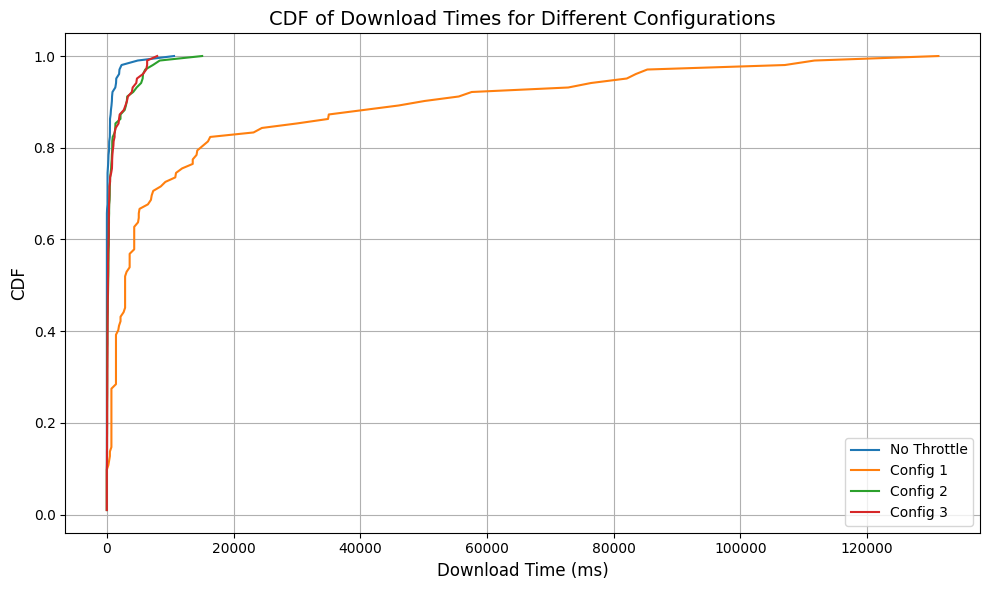

In [369]:
files = {
    "No Throttle": "IndiaPost_nothrottle.har",
    "Config 1": "IndiaPost_Config1.har",
    "Config 2": "IndiaPost_Config2.har",
    "Config 3": "IndiaPost_Config3.har"
}
download_times_dict = {}
for config_name, file in files.items():
    download_times_dict[config_name] = extract_download_times(file)
plot_cdf_dn_time(download_times_dict)

A point (x, y) on the graph indicates that y proportion of response elements had a download time less than or equal to x

Switching the x-axis to logrithimic

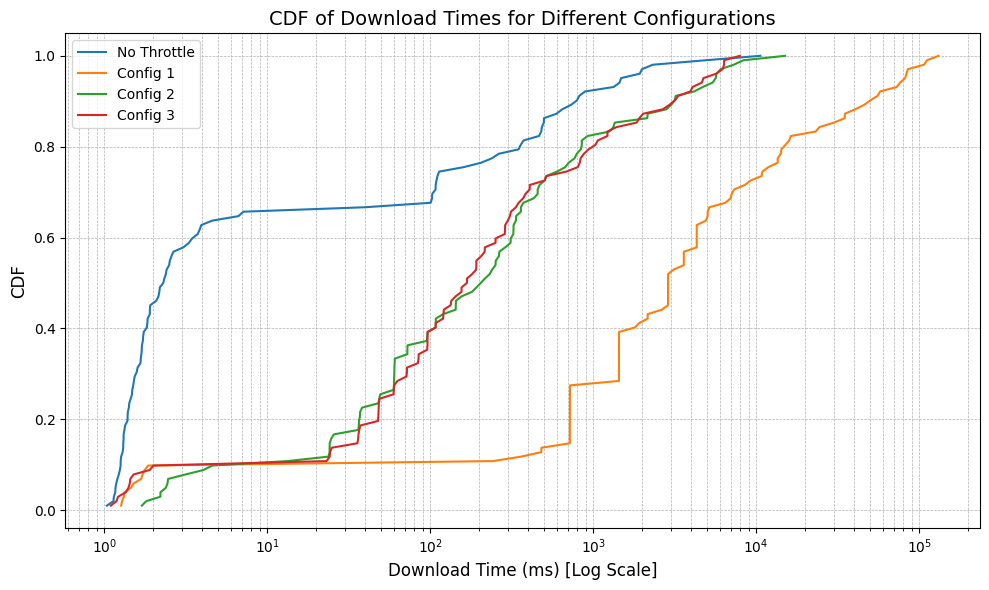

In [370]:
def plot_cdf_dn(download_times_dict):
    """
    Plot the CDF of download times for multiple configurations with a logarithmic x-axis.
    """
    plt.figure(figsize=(10, 6))
    
    for config, times in download_times_dict.items():
        sorted_times = np.sort(times)
        cdf = np.arange(1, len(sorted_times) + 1) / len(sorted_times)
        plt.plot(sorted_times, cdf, label=config)
    plt.xscale('log')
    plt.xlabel("Download Time (ms) [Log Scale]", fontsize=12)
    plt.ylabel("CDF", fontsize=12)
    plt.title("CDF of Download Times for Different Configurations", fontsize=14)
    plt.legend(fontsize=10)
    plt.grid(True, which="both", linestyle="--", linewidth=0.5)  # Grid for both major and minor ticks
    plt.tight_layout()
    
    plt.show()
    files = {
    "No Throttle": "IndiaPost_nothrottle.har",
    "Config 1": "IndiaPost_Config1.har",
    "Config 2": "IndiaPost_Config2.har",
    "Config 3": "IndiaPost_Config3.har"
}
download_times_dict = {}
for config_name, file in files.items():
    download_times_dict[config_name] = extract_download_times(file)
plot_cdf_dn(download_times_dict)

Exercise 2.e 

CDF of response sizes

In [371]:
def extract_response_sizes(file):
    """
    Extract response sizes (in bytes) for all response elements from a HAR file.
    """
    response_sizes = []
    with open(file, 'r') as f:
        har_data = json.load(f)
    for entry in har_data['log']['entries']:
        response = entry.get('response', {})
        body_size = response.get('bodySize', -1)
        if body_size >= 0:
            response_sizes.append(body_size)
    
    return response_sizes

In [372]:
def plot_cdf_res_size(response_sizes_dict):
    """
    Plot the CDF of response sizes for multiple configurations.
    """
    plt.figure(figsize=(10, 6))
    
    for config, sizes in response_sizes_dict.items():
        sorted_sizes = np.sort(sizes)
        cdf = np.arange(1, len(sorted_sizes) + 1) / len(sorted_sizes)
        plt.plot(sorted_sizes, cdf, label=config)
    plt.xscale('log')
    plt.xlabel("Response Size (bytes) [Log Scale]", fontsize=12)
    plt.ylabel("CDF", fontsize=12)
    plt.title("CDF of Response Sizes for Different Configurations", fontsize=14)
    plt.legend(fontsize=10)
    plt.grid(True, which="both", linestyle="--", linewidth=0.5) 
    plt.tight_layout()
    plt.show()

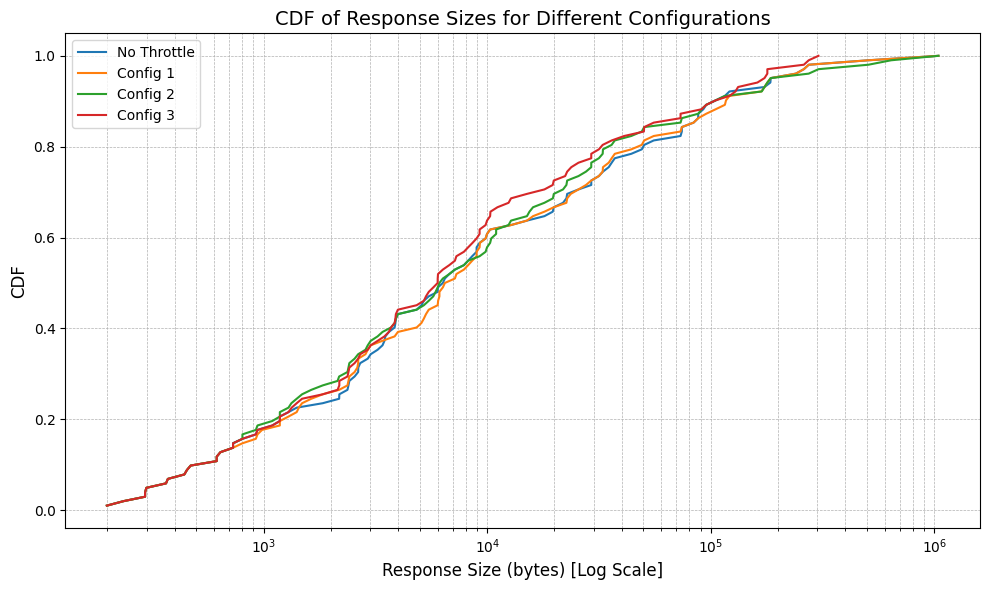

In [373]:
files = {
    "No Throttle": "IndiaPost_nothrottle.har",
    "Config 1": "IndiaPost_Config1.har",
    "Config 2": "IndiaPost_Config2.har",
    "Config 3": "IndiaPost_Config3.har"
}
response_sizes_dict = {}
for config_name, file in files.items():
    response_sizes_dict[config_name] = extract_response_sizes(file)
plot_cdf_res_size(response_sizes_dict)

Exercise 2.f

Scatter Plot: Size vs. Download Time

In [374]:
def extract_size_and_time(file):
    """
    Extract response sizes (in bytes) and download times (in milliseconds) for all response elements from a HAR file.
    """
    sizes = []
    times = []
    with open(file, 'r') as f:
        har_data = json.load(f)
    for entry in har_data['log']['entries']:
        response = entry.get('response', {})
        timings = entry.get('timings', {})
        
        body_size = response.get('bodySize', -1)  
        receive_time = timings.get('receive', -1) 
        if body_size >= 0 and receive_time >= 0:
            sizes.append(body_size)
            times.append(receive_time)
    
    return sizes, times

In [375]:
def plot_scatter_subplots(files):
    fig, axes = plt.subplots(1, 4, figsize=(20, 5), sharey=True)

    for ax, (config_name, file) in zip(axes, files.items()):
        sizes, times = extract_size_and_time(file)
        ax.scatter(sizes, times, alpha=0.6, s=10, color='blue')
        ax.set_title(config_name, fontsize=12)
        ax.set_xlabel("Response Size (bytes)", fontsize=10)
    axes[0].set_ylabel("Download Time (ms)", fontsize=10)
    for ax in axes:
        ax.grid(True, linestyle="--", linewidth=0.5)
    
    plt.suptitle("Scatter Plot: Size vs. Download Time", fontsize=16)
    plt.tight_layout()
    plt.subplots_adjust(top=0.85) 
    plt.show()

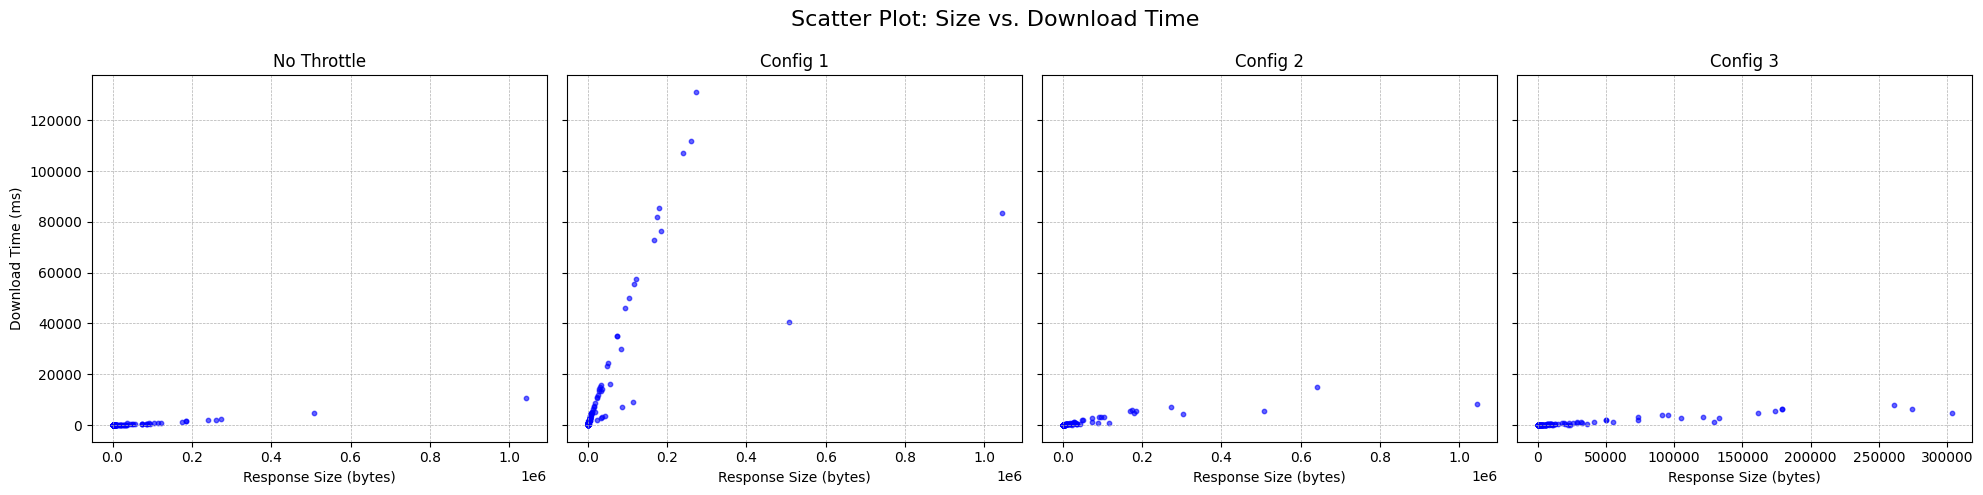

In [376]:
files = {
    "No Throttle": "IndiaPost_nothrottle.har",
    "Config 1": "IndiaPost_Config1.har",
    "Config 2": "IndiaPost_Config2.har",
    "Config 3": "IndiaPost_Config3.har"
}
plot_scatter_subplots(files)

Using log

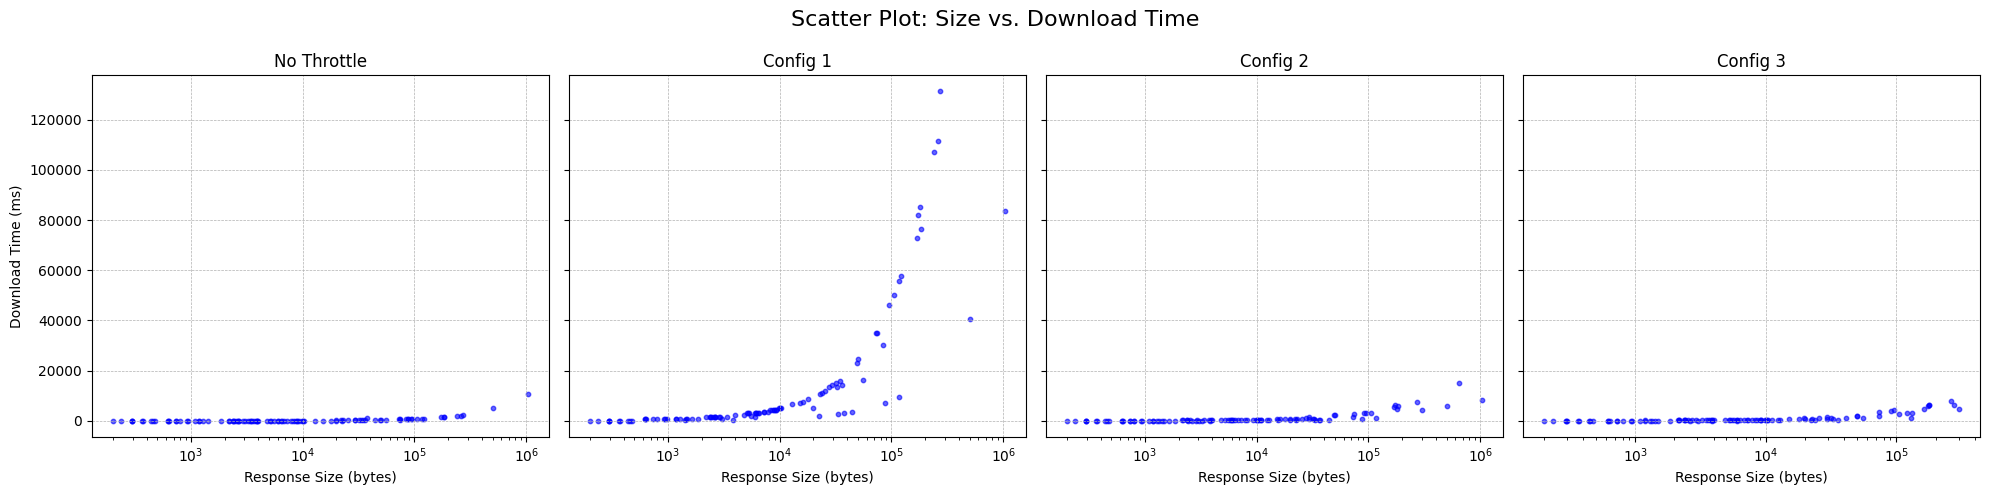

In [377]:
def plot_scatter_subplots_log(files):
    fig, axes = plt.subplots(1, 4, figsize=(20, 5), sharey=True)

    for ax, (config_name, file) in zip(axes, files.items()):
        sizes, times = extract_size_and_time(file)
        ax.scatter(sizes, times, alpha=0.6, s=10, color='blue')
        ax.set_title(config_name, fontsize=12)
        ax.set_xlabel("Response Size (bytes)", fontsize=10)
        ax.set_xscale('log')
    axes[0].set_ylabel("Download Time (ms)", fontsize=10)
    for ax in axes:
        ax.grid(True, linestyle="--", linewidth=0.5)
    
    plt.suptitle("Scatter Plot: Size vs. Download Time", fontsize=16)
    plt.tight_layout()
    plt.subplots_adjust(top=0.85) 
    plt.show()
    files = {
    "No Throttle": "IndiaPost_nothrottle.har",
    "Config 1": "IndiaPost_Config1.har",
    "Config 2": "IndiaPost_Config2.har",
    "Config 3": "IndiaPost_Config3.har"
}
plot_scatter_subplots_log(files)